In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# First make sure required packages are imported
import matplotlib.pyplot as plt
from cheatsheet import CHEATSHEETS
from prompt import PROMPTS
PROMPTS["DEFAULT_ENTITY_TYPES"]
import pandas as pd
                   

In [6]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class MetadataFields:
    metadata_date: Optional[str] = None
    metadata_language: Optional[str] = None
    responsible_organization_metadata: Optional[str] = None
    landing_page: Optional[str] = None
    title: Optional[str] = None
    description: Optional[str] = None
    unique_identifier: Optional[str] = None
    resource_type: Optional[str] = None
    keywords: Optional[str] = None
    data_creator: Optional[str] = None
    data_contact_point: Optional[str] = None
    data_publisher: Optional[str] = None
    spatial_coverage: Optional[str] = None
    spatial_resolution: Optional[str] = None
    spatial_reference_system: Optional[str] = None
    temporal_coverage: Optional[str] = None
    temporal_resolution: Optional[str] = None
    license: Optional[str] = None
    access_rights: Optional[str] = None
    distribution_access_url: Optional[str] = None
    distribution_format: Optional[str] = None
    distribution_byte_size: Optional[str] = None

# Example usage:
metadata = MetadataFields()
# To set values:
metadata.metadata_date = "T"
metadata.metadata_language = "F"
# etc.

In [7]:
def convert_field_name(field_name: str) -> str:
    """Convert field name from text format to attribute format"""
    # Remove colon if present and convert to lowercase
    field_name = field_name.rstrip(':').lower()
    # Replace spaces with underscores
    return field_name.replace(' ', '_')

def extract_indicators(text):
    """
    Extract indicators (- T, - F, - ?) from field values in the text.
    
    Args:
        text (str): Input text containing metadata fields and their indicators
        
    Returns:
        dict: Dictionary with source URLs as keys and MetadataFields objects as values
    """
    label_dict = {}
    current_field = None
    current_url = None
    metadata = MetadataFields()
    
    for line in text.split('\n'):
        line = line.strip()
        
        # Handle Source URL
        if line.startswith('Source URL:'):
            if current_url and metadata:
                label_dict[current_url] = metadata
                metadata = MetadataFields()
            current_url = line.replace('Source URL:', '').strip()
            continue
        
        # Skip separator lines and empty lines
        if line.startswith('===') or not line:
            continue
            
        # If line ends with colon, it's a field name
        if line.endswith(':'):
            current_field = convert_field_name(line)
            continue
            
        # If line starts with dash, it contains an indicator
        if line.startswith('-'):
            if current_field and hasattr(metadata, current_field):
                if 'T' in line[-2:]:  # Check for T in last 2 chars
                    setattr(metadata, current_field, 'T')
                elif 'F' in line[-2:]:  # Check for F in last 2 chars
                    setattr(metadata, current_field, 'F')
                elif '?' in line[-2:]:  # Check for ? in last 2 chars
                    setattr(metadata, current_field, '?')
    
    # Add the last metadata object if it exists
    if current_url and metadata:
        label_dict[current_url] = metadata
                
    return label_dict

# Example usage
sample_text = """==================================================
Source URL: https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json

==================================================
Metadata date:
  - (EcoDataCube, The metadata date is not explicitly mentioned in the text.)
  - T
"""

result = extract_indicators(sample_text)
print(result)

{'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json': MetadataFields(metadata_date='T', metadata_language=None, responsible_organization_metadata=None, landing_page=None, title=None, description=None, unique_identifier=None, resource_type=None, keywords=None, data_creator=None, data_contact_point=None, data_publisher=None, spatial_coverage=None, spatial_resolution=None, spatial_reference_system=None, temporal_coverage=None, temporal_resolution=None, license=None, access_rights=None, distribution_access_url=None, distribution_format=None, distribution_byte_size=None)}


In [8]:
with open('outputs/entity_annotation.txt', 'r') as f:
    sample_text = f.read()

result = extract_indicators(sample_text)
print(result)

{'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz': MetadataFields(metadata_date='T', metadata_language='T', responsible_organization_metadata='T', landing_page='T', title='T', description='?', unique_identifier='T', resource_type=None, keywords='T', data_creator='T', data_contact_point='?', data_publisher='?', spatial_coverage='T', spatial_resolution='T', spatial_reference_system='T', temporal_coverage='T', temporal_resolution='T', license='T', access_rights=None, distribution_access_url='F', distribution_format='T', distribution_byte_size='?'), 'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e': MetadataFields(metadata_date='T', metadata_language='T', responsible_organization_metadata='T', landing_page='T', title='T', description='T', unique_identifier='T', resource_type='?', keywords='T', data_creator='?', data_contact_point='T', data_publisher='T', spatial_coverage='F', spatial_resolution='T', spatial_reference_system='T',

In [9]:
result

{'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz': MetadataFields(metadata_date='T', metadata_language='T', responsible_organization_metadata='T', landing_page='T', title='T', description='?', unique_identifier='T', resource_type=None, keywords='T', data_creator='T', data_contact_point='?', data_publisher='?', spatial_coverage='T', spatial_resolution='T', spatial_reference_system='T', temporal_coverage='T', temporal_resolution='T', license='T', access_rights=None, distribution_access_url='F', distribution_format='T', distribution_byte_size='?'),
 'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e': MetadataFields(metadata_date='T', metadata_language='T', responsible_organization_metadata='T', landing_page='T', title='T', description='T', unique_identifier='T', resource_type='?', keywords='T', data_creator='?', data_contact_point='T', data_publisher='T', spatial_coverage='F', spatial_resolution='T', spatial_reference_system='T'

In [19]:
def extract_evals_from_csv(filepath_csv='outputs/2025-05-20entity_type_map_2025-05-21_10-40_verification_results.csv'):
    df_evals = pd.read_csv(filepath_csv)
    result = {}
    url = None
    for ii in range(len(df_evals)):
        curr_url = df_evals.iloc[ii]['url']
        if curr_url != url:
            if url is not None:
                result[url] = metadata
            url = curr_url
            metadata = MetadataFields()
        field_name = convert_field_name(df_evals.iloc[ii]['field'])
        assert field_name in metadata.__dict__, f"Field {field_name} not found in MetadataFields"
        setattr(metadata, field_name, df_evals.iloc[ii]['evaluation'])

    if url is not None:
        result[url] = metadata
    return result

result = extract_evals_from_csv()

In [20]:
def calculate_overall_stats(results: dict) -> dict:
    """Calculate overall statistics for all datasets"""
    total_fields = 0
    counts = {'T': 0, 'F': 0, '?': 0, 'Missing': 0}
    
    for metadata in results.values():
        for value in vars(metadata).values():
            total_fields += 1
            if value in counts:
                counts[value] += 1
            else:
                counts['Missing'] += 1
    
    percentages = {
        key: (count / total_fields * 100) if total_fields > 0 else 0 
        for key, count in counts.items()
    }
    
    return {
        'counts': counts,
        'percentages': percentages,
        'total_fields': total_fields
    }

def calculate_dataset_stats(results: dict) -> dict:
    """Calculate statistics for each dataset"""
    dataset_stats = {}
    
    for url, metadata in results.items():
        counts = {'T': 0, 'F': 0, '?': 0, 'Missing': 0}
        total = 0
        
        for value in vars(metadata).values():
            total += 1
            if value in counts:
                counts[value] += 1
            else:
                counts['Missing'] += 1
        
        dataset_stats[url] = {
            'counts': counts,
            'percentages': {
                key: (count / total * 100) if total > 0 else 0 
                for key, count in counts.items()
            },
            'total_fields': total
        }
    
    return dataset_stats

def calculate_attribute_stats(results: dict) -> dict:
    """Calculate statistics for each metadata attribute"""
    attribute_stats = {}
    
    # Initialize counters for each attribute
    for field in vars(next(iter(results.values()))).keys():
        attribute_stats[field] = {'T': 0, 'F': 0, '?': 0, 'Missing': 0}
    
    # Count occurrences
    total_datasets = len(results)
    for metadata in results.values():
        for field, value in vars(metadata).items():
            if value in attribute_stats[field]:
                attribute_stats[field][value] += 1
            else:
                attribute_stats[field]['Missing'] += 1
    
    # Calculate percentages
    for field in attribute_stats:
        attribute_stats[field]['percentages'] = {
            key: (count / total_datasets * 100) 
            for key, count in attribute_stats[field].items() 
            if key != 'percentages'
        }
    
    return attribute_stats

# Calculate and print all statistics
def print_all_stats(results: dict):
    """Print all statistics in a readable format"""
    
    print("1. Overall Statistics:")
    overall_stats = calculate_overall_stats(results)
    print(f"Total fields analyzed: {overall_stats['total_fields']}")
    print("Percentages:")
    for key, value in overall_stats['percentages'].items():
        print(f"  {key}: {value:.2f}%")
    
    print("\n2. Dataset Statistics:")
    dataset_stats = calculate_dataset_stats(results)
    for url, stats in dataset_stats.items():
        print(f"\nDataset: {url}")
        print("Percentages:")
        for key, value in stats['percentages'].items():
            print(f"  {key}: {value:.2f}%")
    
    print("\n3. Attribute Statistics:")
    attribute_stats = calculate_attribute_stats(results)
    for field, stats in attribute_stats.items():
        print(f"\n{field}:")
        print("Percentages:")
        for key, value in stats['percentages'].items():
            print(f"  {key}: {value:.2f}%")

# Use this with your results
print_all_stats(result)

1. Overall Statistics:
Total fields analyzed: 308
Percentages:
  T: 70.45%
  F: 18.51%
  ?: 4.87%
  Missing: 6.17%

2. Dataset Statistics:

Dataset: https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002
Percentages:
  T: 81.82%
  F: 13.64%
  ?: 4.55%
  Missing: 0.00%

Dataset: https://lpdaac.usgs.gov/products/mod09a1v061/
Percentages:
  T: 100.00%
  F: 0.00%
  ?: 0.00%
  Missing: 0.00%

Dataset: https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en
Percentages:
  T: 77.27%
  F: 13.64%
  ?: 9.09%
  Missing: 0.00%

Dataset: https://stac.ecodatacube.eu/ndvi_glad.landsat.ard2.seasconv/collection.json?.language=en
Percentages:
  T: 59.09%
  F: 31.82%
  ?: 9.09%
  Missing: 0.00%

Dataset: https://zenodo.org/records/8319440
Percentages:
  T: 59.09%
  F: 40.91%
  ?: 0.00%
  Missing: 0.00%

Dataset: https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz
Percentages:
  T: 68.18%
  F: 31.82%
  ?: 0.00%
  M

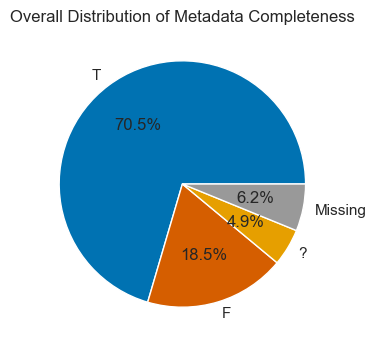

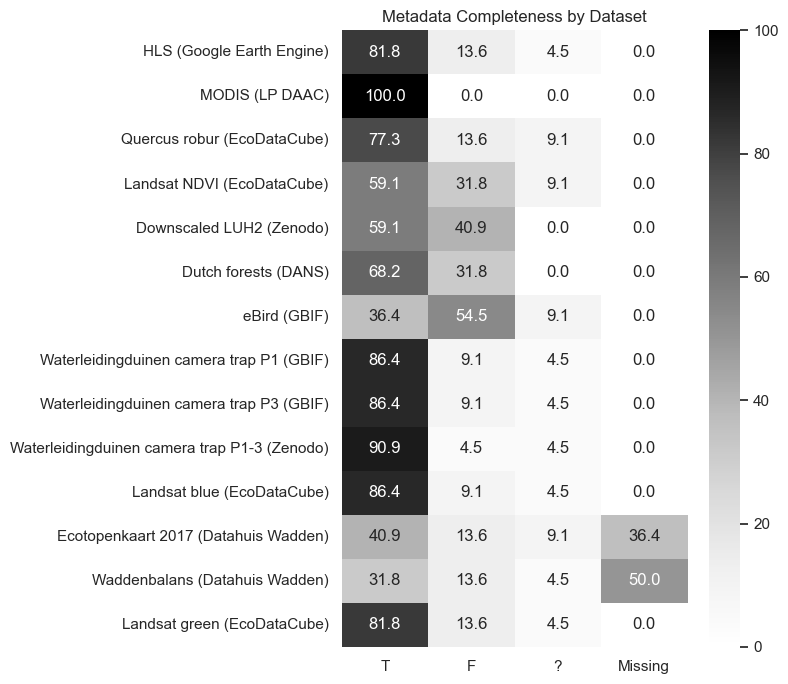

<Figure size 800x800 with 0 Axes>

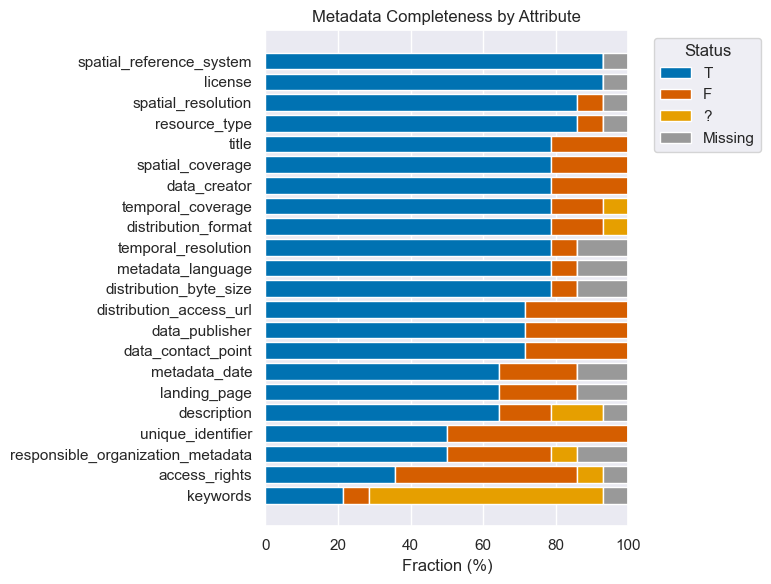

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os, sys
from datetime import datetime

def plot_statistics(results: dict, save_figs=False, folder_save=None):
    """Create visualizations for metadata statistics"""
    # Set style to a built-in matplotlib style
    plt.style.use('default')
    if folder_save is None:
        folder_save = 'figs/'
        assert os.path.exists(folder_save), f"Folder {folder_save} does not exist."
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    # Set figure aesthetics
    sns.set_theme()
    colour_dict = {
        'T': '#0072B2',       # Blue
        'F': '#D55E00',       # Vermilion (reddish-orange)
        '?': '#E69F00',       # Orange
        'Missing': '#999999'  # Grey
    }
    ## get titles of dataset:
    url_to_ds_name = {
    'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz': 'Dutch forests (DANS)',
    'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e': 'eBird (GBIF)',
    'https://www.gbif.org/dataset/74196cd9-7ebc-4b20-bc27-3c2d22e31ed7': 'Waterleidingduinen camera trap P1 (GBIF)',
    'https://www.gbif.org/dataset/bc0acb9a-131f-4085-93ae-a46e08564ac5': 'Waterleidingduinen camera trap P3 (GBIF)',
    'https://zenodo.org/records/11440456': 'Waterleidingduinen camera trap P1-3 (Zenodo)',
    'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Landsat blue (EcoDataCube)',
    'https://stac.ecodatacube.eu/green_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Landsat green (EcoDataCube)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/api/records/A0h06_NlSEuNlium5OO3FA': 'Ecotopenkaart 2016 (Datahuis Wadden)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/L-mHomzGRuKAHGMkUPjY9g': 'Ecotopenkaart 2017 (Datahuis Wadden)',
    'https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002': 'HLS (Google Earth Engine)',
    'https://lpdaac.usgs.gov/products/mod09a1v061/': 'MODIS (LP DAAC)',
    'https://stac.ecodatacube.eu/ndvi_glad.landsat.ard2.seasconv/collection.json?.language=en': 'Landsat NDVI (EcoDataCube)',
    'https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en': 'Quercus robur (EcoDataCube)',
    'https://zenodo.org/records/8319440': 'Downscaled LUH2 (Zenodo)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/0fe7e64b-50b3-4cee-b64a-02659fc2b6c7': 'Waddenbalans (Datahuis Wadden)',
    }

    # 1. Overall Statistics Pie Chart
    plt.figure(figsize=(4, 4))
    overall_stats = calculate_overall_stats(results)
    # colors = sns.color_palette('husl', n_colors=len(overall_stats['percentages']))
    plt.pie(overall_stats['percentages'].values(), 
            labels=overall_stats['percentages'].keys(),
            autopct='%1.1f%%',
            colors=[colour_dict[key] for key in overall_stats['percentages'].keys()])
            # colors=colors)
    plt.title('Overall Distribution of Metadata Completeness')
    # plt.show()
    if save_figs:
        plt.savefig(os.path.join(folder_save, f'overall_stats_{timestamp}.pdf'), bbox_inches='tight')
        plt.close()

    # 2. Dataset Statistics Heatmap
    dataset_stats = calculate_dataset_stats(results)
    dataset_data = []
    for url, stats in dataset_stats.items():
        row = stats['percentages']
        row['URL'] = url
        dataset_data.append(row)
    
    df_datasets = pd.DataFrame(dataset_data)
    plt.figure(figsize=(8, len(dataset_data) * 0.5))
    sns.heatmap(df_datasets.drop('URL', axis=1), 
                annot=True, 
                fmt='.1f',
                cmap='Greys',
                yticklabels=[url_to_ds_name.get(url, url) for url in df_datasets['URL']])
    plt.title('Metadata Completeness by Dataset')
    plt.tight_layout()
    # plt.show()
    if save_figs:
        plt.savefig(os.path.join(folder_save, f'dataset_stats_{timestamp}.pdf'), bbox_inches='tight')
        plt.close()

    # 3. Attribute Statistics Bar Chart
    attribute_stats = calculate_attribute_stats(results)
    attr_data = []
    for field, stats in attribute_stats.items():
        row = stats['percentages']
        row['Field'] = field
        attr_data.append(row)
    
    df_attrs = pd.DataFrame(attr_data)
    
    plt.figure(figsize=(8, 8))
    df_attrs_melted = df_attrs.melt(id_vars=['Field'], 
                                   var_name='Status', 
                                   value_name='Percentage')
    
    # Calculate cumulative percentages for stacked bar chart
    df_attrs_melted['Cumulative'] = df_attrs_melted.groupby('Field')['Percentage'].cumsum() - df_attrs_melted['Percentage']
    # Pivot the table
    pivot_df = df_attrs_melted.pivot_table(index='Field', 
                            columns='Status', 
                            values='Percentage', 
                            fill_value=0)

    # pivot_df = pivot_df.reindex(pivot_df['T'].sort_values(ascending=False).index)
    pivot_df = pivot_df.sort_values(by=['T', 'F'], ascending=[True, True])
    pivot_df = pivot_df.reset_index()
    # Plot using matplotlib for stacked bars
    # Plot horizontal stacked bars
    fig, ax = plt.subplots(figsize=(8, 6))
    left = np.zeros(len(pivot_df))  # For horizontal bars, use "left" instead of "bottom"

    for status in colour_dict.keys():
        width = pivot_df[status].values
        ax.barh(np.arange(len(pivot_df)), width, left=left, 
                color=colour_dict[status], label=status)
        left += width

    # Set y-axis to field names
    ax.set_yticks(np.arange(len(pivot_df)))
    ax.set_yticklabels(pivot_df['Field'])
    ax.set_xlabel('Fraction (%)')
    ax.set_title('Metadata Completeness by Attribute')
    ax.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    # plt.show()
    if save_figs:
        plt.savefig(os.path.join(folder_save, f'attribute_stats_{timestamp}.pdf'), bbox_inches='tight')
        plt.close()



# Use this to create the plots
tmp = plot_statistics(result, save_figs=False, folder_save='figs/')

In [46]:
dataset_stats = calculate_dataset_stats(result)
dataset_stats

{'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz': {'counts': {'T': 15,
   'F': 1,
   '?': 4,
   'Missing': 2},
  'percentages': {'T': 68.18181818181817,
   'F': 4.545454545454546,
   '?': 18.181818181818183,
   'Missing': 9.090909090909092},
  'total_fields': 22},
 'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e': {'counts': {'T': 19,
   'F': 1,
   '?': 2,
   'Missing': 0},
  'percentages': {'T': 86.36363636363636,
   'F': 4.545454545454546,
   '?': 9.090909090909092,
   'Missing': 0.0},
  'total_fields': 22},
 'https://www.gbif.org/dataset/74196cd9-7ebc-4b20-bc27-3c2d22e31ed7': {'counts': {'T': 17,
   'F': 2,
   '?': 3,
   'Missing': 0},
  'percentages': {'T': 77.27272727272727,
   'F': 9.090909090909092,
   '?': 13.636363636363635,
   'Missing': 0.0},
  'total_fields': 22},
 'https://www.gbif.org/dataset/bc0acb9a-131f-4085-93ae-a46e08564ac5': {'counts': {'T': 15,
   'F': 3,
   '?': 4,
   'Missing': 0},
  'percentages': {

In [62]:
{k: '' for k in result.keys()}

{'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz': '',
 'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e': '',
 'https://www.gbif.org/dataset/74196cd9-7ebc-4b20-bc27-3c2d22e31ed7': '',
 'https://www.gbif.org/dataset/bc0acb9a-131f-4085-93ae-a46e08564ac5': '',
 'https://zenodo.org/records/11440456': '',
 'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json': '',
 'https://stac.ecodatacube.eu/green_glad.landsat.ard2.seasconv.m.yearly/collection.json': '',
 'https://datahuiswadden.openearth.nl/geonetwork/srv/api/records/A0h06_NlSEuNlium5OO3FA': '',
 'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/L-mHomzGRuKAHGMkUPjY9g': ''}